In [1]:
import pickle
import pandas as pd
import numpy as np
# from pathlib import Path
import joblib
# import itertools as it
import py4DSTEM
# import glob
import os
from random import sample
# from time import time
# import collections
# from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from typing import Union, Optional
from scipy.signal import medfilt
# from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import os
import sklearn
import sys 
%load_ext autoreload
%autoreload 2

### <font size="5">  Clone this repo in a folder called "repos" and this pathing will work without any edits

In [2]:
%cd "~/repos/EDiffCrystals/src/package/"
from diffraction_analysis import Diffraction_Analysis
from diffraction_analysis_utils import *

C:\Users\smgls\repos\EDiffCrystals\src\package


In [3]:
py4DSTEM.__version__

'0.14.8'

In [4]:
sklearn.__version__

'1.2.1'

### <font size="5"> Load data and models

In [5]:
file_path = "C:/Users/smgls/repos/EDiffCrystals/data/EDiffCrystals_AuNPs/"
file_data = file_path + '240130-gold-nanobeam-00_master.h5'
# file_probe = file_path + 'vacuum_probe_03.dm4'
file_analysis = file_path + 'analysis_dataset00_'

bin_factor = 1

# pl_filepath = 'C:/Users/smgls/repos/EDiffCrystals/data/EDiffCrystals_AuNPs/Au_dataset00_braggdisks_cali.h5'
pl_filepath = "C:/Users/smgls/Downloads/Disk detection reference/240130/gold sam/TEST_disk_detection_051324_v2/analysis_dataset00_TEST_braggdisks_cali.h5"

model_path_header = 'C:/Users/smgls/repos/EDiffCrystals/models/Random_Forest_Models/'

crystal_system_model_path = model_path_header+'crystal_system_model.joblib'
cubic_lattice_model_path = model_path_header+'cubic_lattice_model.joblib'
hexagonal_lattice_model_path = model_path_header+'hexagonal_lattice_model.joblib'
tetragonal_lattice_model_path = model_path_header+'tetragonal_lattice_model.joblib'
trigonal_lattice_model_path = model_path_header+'trigonal_lattice_model.joblib'
monoclinic_lattice_model_path = model_path_header+'monoclinic_lattice_model.joblib'
orthorhombic_lattice_model_path = model_path_header+'orthorhombic_lattice_model.joblib'

In [6]:
model_path_dicts = {
    'cry_sys':crystal_system_model_path,
    'cubic':cubic_lattice_model_path,
    'hexagonal':hexagonal_lattice_model_path,
    'tetragonal':tetragonal_lattice_model_path,
    'trigonal':trigonal_lattice_model_path,
    'monoclinic':monoclinic_lattice_model_path,
    'orthorhombic':orthorhombic_lattice_model_path,
}

In [7]:
diff_analysis = Diffraction_Analysis(
    pl_filepath = pl_filepath, 
    model_path_dict = model_path_dicts, 
)

In [8]:
diff_analysis.load_pls()

loading point lists stored at C:/Users/smgls/Downloads/Disk detection reference/240130/gold sam/TEST_disk_detection_051324_v2/analysis_dataset00_TEST_braggdisks_cali.h5


Reading PointListArray: 100%|███████████████████████████████████████████| 65536/65536 [00:11<00:00, 5660.50PointList/s]


### <font size="5"> Load raw patterns

Dataset is uint32 but will be converted to uint16


Cleaning pixels: 100%|████████████████████████████████████████████████████| 65536/65536 [00:07<00:00, 8442.72 images/s]


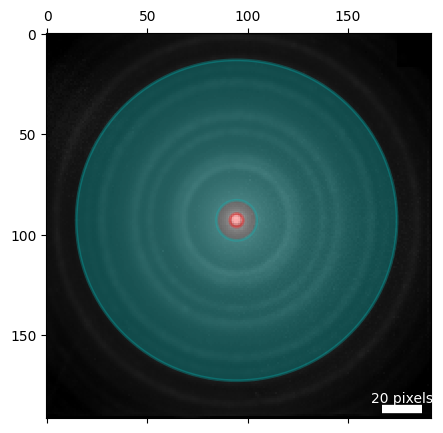

In [9]:
dataset = py4DSTEM.import_file(
    file_data,
    binfactor=bin_factor,
    scan_width=256,
)
dataset.get_dp_mean();

dataset, mask = py4DSTEM.preprocess.filter_hot_pixels(
    dataset,
    thresh=10 * bin_factor ** 2,
    return_mask=True,
    ind_compare=2,

)

dataset.get_dp_mean();
dataset.get_dp_max();

# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = dataset.get_probe_size(
    thresh_lower=0.5,
    thresh_upper=0.6,
)

# virtual BF and DF

expand_BF = 2
radii_DF = (10 / bin_factor, 80 / bin_factor)

center = (probe_qx0, probe_qy0)
radius_BF = probe_semiangle + expand_BF

# Plot the detectors
py4DSTEM.visualize.show(
    dataset.tree('dp_mean'),
    annulus={
        'center': center,
        'radii': radii_DF,
        'alpha': 0.3,
        'fill': True,
        'color': 'c',
    },
    circle={
        'center': center,
        'R': radius_BF,
        'alpha': 0.3,
        'fill': True,
        'color': 'r',
    },
    vmax=1,
    scaling='log',
)

100%|█████████████████████████████████████████████████████████████████████████| 65536/65536 [00:06<00:00, 10293.84it/s]


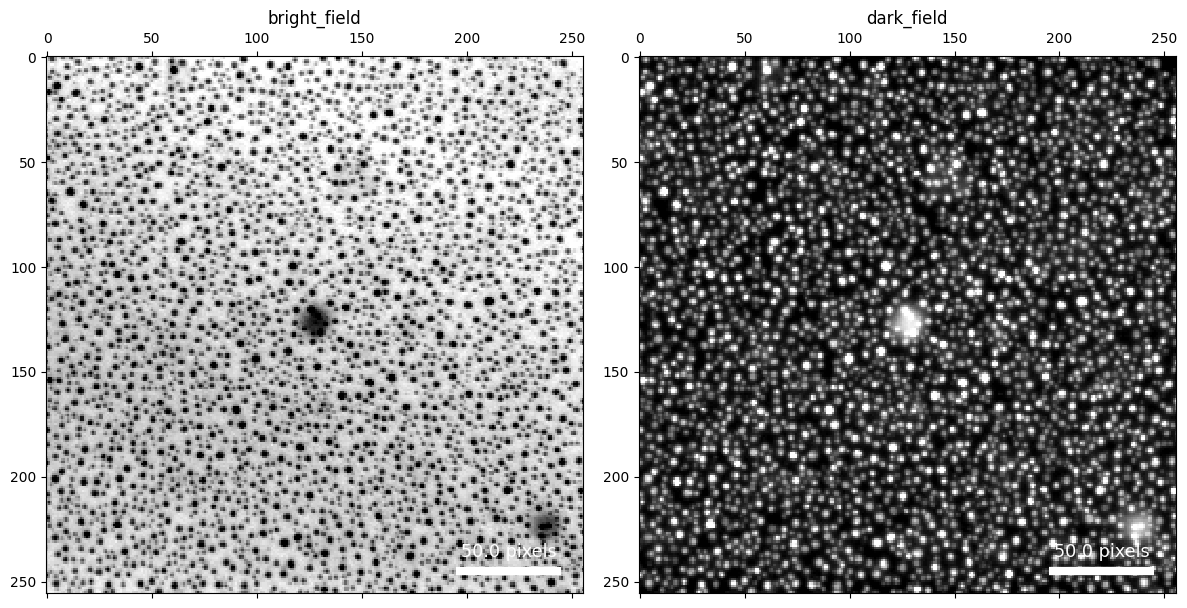

In [10]:
# Generate virtual images
dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius_BF),
    name = 'bright_field',
)
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii_DF),
    name = 'dark_field',
);

fig,ax = py4DSTEM.show(
    [
        dataset.tree('bright_field'),
        dataset.tree('dark_field'),
    ],
    figsize=(12,7),
    # bordercolor = 'w',
    cmap='gray',
    returnfig = True,
    title = [
        'bright_field',
        'dark_field',
    ],
    ticks = True,
)

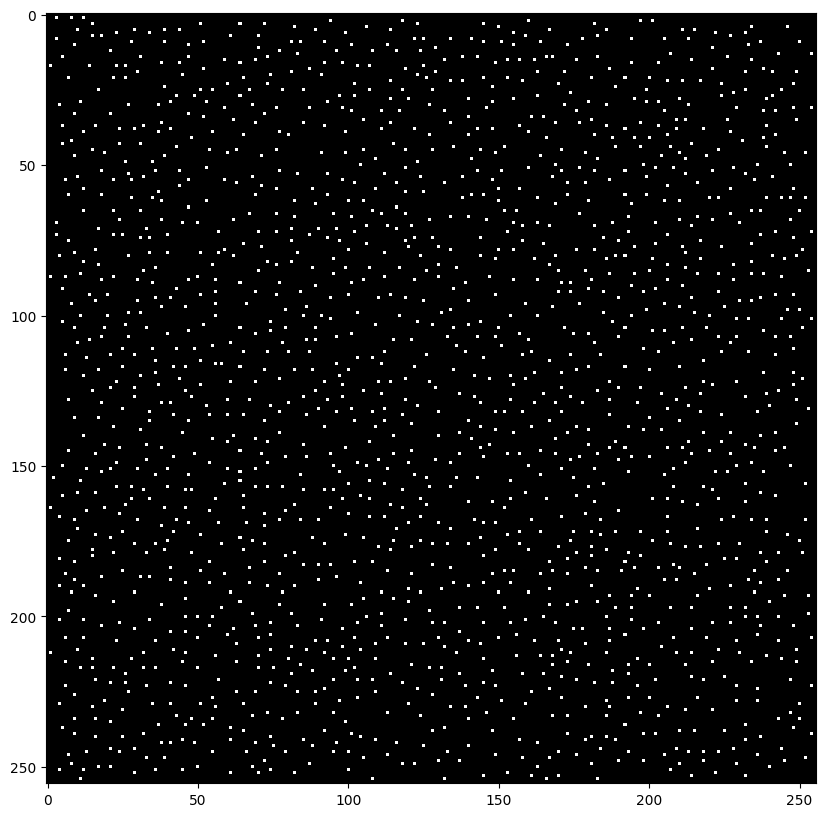

In [11]:
mask_keep = threshold_particles(
    dataset.tree('dark_field').data,
    threshold = 1e4,
    sigma = 1.0,
)
mask_keep = mask_keep.astype('int')

In [10]:
# pls_ref = py4DSTEM.read(pl_filepath)

### <font size="5"> Load Bragg Disk Array (see 

In [12]:
# count = []
# for i in range(pls_ref.shape[0]):
#     for j in range(pls_ref.shape[1]):
#         diff = len(pls_ref.cal[i,j].data) - len(pls.cal[i,j].data)
#         # if diff > 3:
#             # if len(pls_ref.cal[i,j].data) > 8:
#                 # print(i,j)
#         count.append(diff)

In [12]:
path = os.path.normpath(pl_filepath)
path = path.split(os.sep)

In [13]:
sum_scaling = 0.3
num_spots_needed = 5


sum_scaling_str = str(sum_scaling).replace('.', '_')
pl_filepath_str = path[-1].replace('.', '_')

save_path = pl_filepath_str + '_' + str(num_spots_needed) + '_spots_required_sum_scaling_' + sum_scaling_str + '_' +'including_lattice.pkl'

In [14]:
save_path

'analysis_dataset00_TEST_braggdisks_cali_h5_5_spots_required_sum_scaling_0_3_including_lattice.pkl'

In [15]:
diff_analysis.prep_pls_for_prediction(sum_scaling = sum_scaling, num_spots_needed=num_spots_needed, remove_central_beam=True)

scaling patterns to sum intensity = 0.3 and filtering out patterns with fewer than 5 diffraction spots


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [03:04<00:00,  1.39it/s]

finished scaling and filtering!


In [16]:
diff_analysis.predict_set_of_point_lists(lattice_pred_type = 'cubic', 
                                           save_df=False, 
                                         save_path=save_path)

loading crystal system model
crystal system model loaded!
building input vector
finished input vector
predicting input vector
starting


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed:    0.3s finished
100%|█████████████████████████████████████████████████████████████████████████| 44600/44600 [00:01<00:00, 35335.31it/s]


loading cubic
cubic loaded!


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [03:07<00:00,  2.35s/it]


finished predictions, adding confidence


100%|██████████████████████████████████████████████████████████████████████████| 44600/44600 [00:28<00:00, 1547.14it/s]


In [17]:
diff_analysis.df_predictions

,label,prediction,full_predictions,input_vector,pl_indicies,lattice_full_predictions_a,lattice_full_predictions_b,lattice_full_predictions_c,a_median,b_median,c_median,Difference_Confidence,Confidence
0,NA,hexagonal,"[tetragonal, tetragonal, cubic, cubic, monocli...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1]","[[2.82, 2.69, 2.87, 2.75, 2.47, 3.11, 3.81, 3....","[[2.82, 2.69, 2.87, 2.75, 2.47, 3.11, 3.81, 3....","[[4.56, 4.38, 5.71, 4.33, 7.8, 3.35, 3.89, 3.1...",3.02,3.02,3.64,0.0250,0.3375
1,NA,tetragonal,"[orthorhombic, cubic, tetragonal, tetragonal, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 2]","[[2.9500000000000006, 3.39, 2.88, 4.07, 4.41, ...","[[2.9500000000000006, 3.39, 2.88, 4.07, 4.41, ...","[[3.4500000000000006, 5.03, 3.87, 3.38, 2.91, ...",3.37,3.37,4.605,0.0375,0.3000
2,NA,hexagonal,"[trigonal, cubic, monoclinic, hexagonal, trigo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 3]","[[4.25, 2.89, 2.84, 2.92, 5.03, 5.47, 3.07, 2....","[[4.25, 2.89, 2.84, 2.92, 5.03, 5.47, 3.07, 2....","[[5.37, 13.1, 12.42, 10.45, 7.02, 3.02, 18.62,...",4.485,4.485,7.14,0.0500,0.3000
3,NA,tetragonal,"[trigonal, cubic, monoclinic, hexagonal, trigo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 4]","[[4.23, 10.45, 4.49, 3.57, 3.93, 3.6, 3.58, 3....","[[4.23, 10.45, 4.49, 3.57, 3.93, 3.6, 3.58, 3....","[[3.52, 5.14, 3.09, 7.51, 15.79, 6.37, 6.91, 6...",3.6,3.6,6.35,0.0125,0.2500
4,NA,hexagonal,"[cubic, hexagonal, monoclinic, cubic, cubic, h...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 5]","[[3.2000000000000006, 2.69, 3.81, 3.11, 2.47, ...","[[3.2000000000000006, 2.69, 3.81, 3.11, 2.47, ...","[[4.04, 4.38, 3.8699999999999997, 3.35, 7.8, 3...",2.965,2.965,3.84,0.0125,0.3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44595,NA,tetragonal,"[monoclinic, orthorhombic, cubic, cubic, cubic...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255, 249]","[[3.89, 4.24, 6.08, 4.06, 4.34, 4.83, 3.829999...","[[3.89, 4.24, 6.08, 4.06, 4.34, 4.83, 3.829999...","[[7.52, 6.760000000000001, 4.97, 10.83, 6.81, ...",4.34,4.34,7.245,0.0375,0.2500
44596,NA,tetragonal,"[hexagonal, trigonal, monoclinic, cubic, tetra...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255, 252]","[[2.99, 3.75, 3.03, 4.23, 4.02, 3.46, 3.32, 7....","[[2.99, 3.75, 3.03, 4.23, 4.02, 3.46, 3.32, 7....","[[3.85, 6.6, 7.4, 2.69, 5.09, 9.64, 8.18, 3.67...",3.75,3.75,6.705,0.0375,0.2750
44597,NA,cubic,"[hexagonal, cubic, tetragonal, cubic, tetragon...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255, 253]","[[4.84, 7.91, 4.09, 4.23, 3.48, 4.2, 3.53, 3.3...","[[4.84, 7.91, 4.09, 4.23, 3.48, 4.2, 3.53, 3.3...","[[4.84, 7.91, 4.09, 4.23, 3.48, 4.2, 3.53, 3.3...",4.22,4.22,4.22,0.0000,0.2250
44598,NA,tetragonal,"[hexagonal, trigonal, trigonal, monoclinic, or...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255, 254]","[[3.25, 3.25, 3.03, 3.36, 4.92, 3.81, 3.27, 7....","[[3.25, 3.25, 3.03, 3.36, 4.92, 3.81, 3.27, 7....","[[2.64, 2.64, 7.4, 7.01, 2.74, 7.52, 10.77, 3....",3.36,3.36,4.91,0.1250,0.3125


In [77]:
pred_df_updated_test

,label,prediction,full_predictions,input_vector,pl_indicies,lattice_full_predictions_a,lattice_full_predictions_b,lattice_full_predictions_c,a_median,b_median,c_median,Difference_Confidence,Confidence
0,NA,hexagonal,"[tetragonal, tetragonal, cubic, cubic, monocli...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 1]","[[2.82, 2.69, 2.87, 2.75, 2.47, 3.11, 3.81, 3....","[[2.82, 2.69, 2.87, 2.75, 2.47, 3.11, 3.81, 3....","[[4.56, 4.38, 5.71, 4.33, 7.8, 3.35, 3.89, 3.1...",3.02,3.02,3.64,0.0250,0.3375
1,NA,tetragonal,"[orthorhombic, cubic, tetragonal, tetragonal, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 2]","[[2.9500000000000006, 3.39, 2.88, 4.07, 4.41, ...","[[2.9500000000000006, 3.39, 2.88, 4.07, 4.41, ...","[[3.4500000000000006, 5.03, 3.87, 3.38, 2.91, ...",3.37,3.37,4.605,0.0375,0.3000
2,NA,hexagonal,"[trigonal, cubic, monoclinic, hexagonal, trigo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 3]","[[4.25, 2.89, 2.84, 2.92, 5.03, 5.47, 3.07, 2....","[[4.25, 2.89, 2.84, 2.92, 5.03, 5.47, 3.07, 2....","[[5.37, 13.1, 12.42, 10.45, 7.02, 3.02, 18.62,...",4.485,4.485,7.14,0.0500,0.3000
3,NA,tetragonal,"[trigonal, cubic, monoclinic, hexagonal, trigo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 4]","[[4.23, 10.45, 4.49, 3.57, 3.93, 3.6, 3.58, 3....","[[4.23, 10.45, 4.49, 3.57, 3.93, 3.6, 3.58, 3....","[[3.52, 5.14, 3.09, 7.51, 15.79, 6.37, 6.91, 6...",3.6,3.6,6.35,0.0125,0.2500
4,NA,hexagonal,"[cubic, hexagonal, monoclinic, cubic, cubic, h...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 5]","[[3.2000000000000006, 2.69, 3.81, 3.11, 2.47, ...","[[3.2000000000000006, 2.69, 3.81, 3.11, 2.47, ...","[[4.04, 4.38, 3.8699999999999997, 3.35, 7.8, 3...",2.965,2.965,3.84,0.0125,0.3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44595,NA,tetragonal,"[monoclinic, orthorhombic, cubic, cubic, cubic...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255, 249]","[[3.89, 4.24, 6.08, 4.06, 4.34, 4.83, 3.829999...","[[3.89, 4.24, 6.08, 4.06, 4.34, 4.83, 3.829999...","[[7.52, 6.760000000000001, 4.97, 10.83, 6.81, ...",4.34,4.34,7.245,0.0375,0.2500
44596,NA,tetragonal,"[hexagonal, trigonal, monoclinic, cubic, tetra...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255, 252]","[[2.99, 3.75, 3.03, 4.23, 4.02, 3.46, 3.32, 7....","[[2.99, 3.75, 3.03, 4.23, 4.02, 3.46, 3.32, 7....","[[3.85, 6.6, 7.4, 2.69, 5.09, 9.64, 8.18, 3.67...",3.75,3.75,6.705,0.0375,0.2750
44597,NA,cubic,"[hexagonal, cubic, tetragonal, cubic, tetragon...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255, 253]","[[4.84, 7.91, 4.09, 4.23, 3.48, 4.2, 3.53, 3.3...","[[4.84, 7.91, 4.09, 4.23, 3.48, 4.2, 3.53, 3.3...","[[4.84, 7.91, 4.09, 4.23, 3.48, 4.2, 3.53, 3.3...",4.22,4.22,4.22,0.0000,0.2250
44598,NA,tetragonal,"[hexagonal, trigonal, trigonal, monoclinic, or...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[255, 254]","[[3.25, 3.25, 3.03, 3.36, 4.92, 3.81, 3.27, 7....","[[3.25, 3.25, 3.03, 3.36, 4.92, 3.81, 3.27, 7....","[[2.64, 2.64, 7.4, 7.01, 2.74, 7.52, 10.77, 3....",3.36,3.36,4.91,0.1250,0.3125


[0.5281663516068068, 0.34319470699432847, 0.1286389413988647]


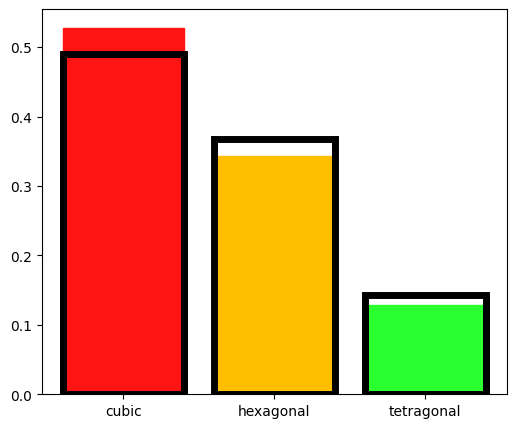

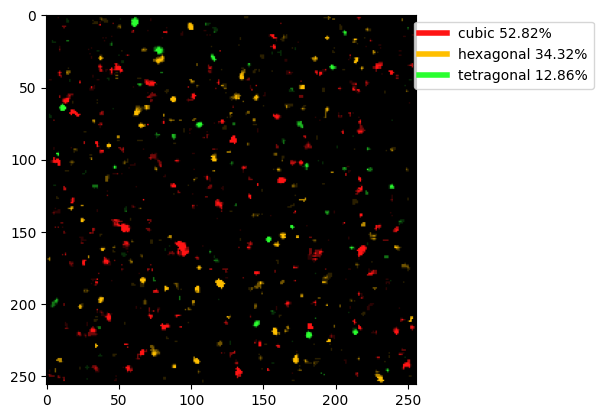

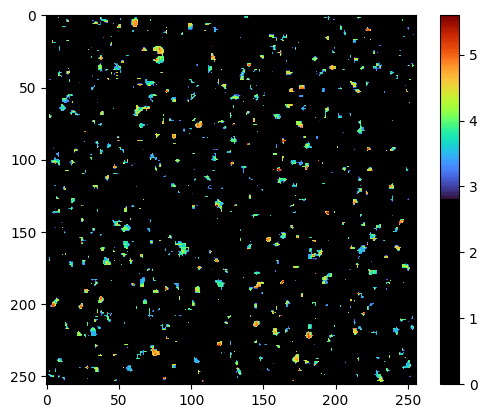

['cubic', 'hexagonal', 'tetragonal']
['cubic', 'hexagonal', 'tetragonal']


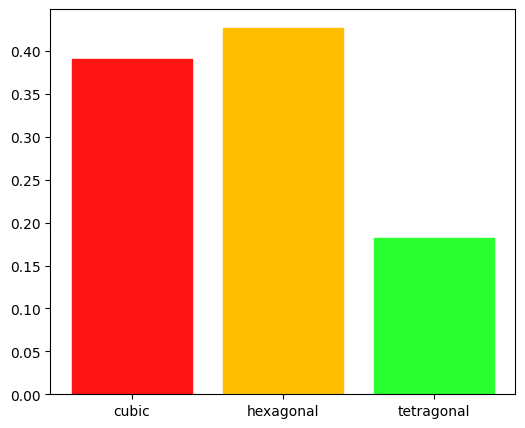

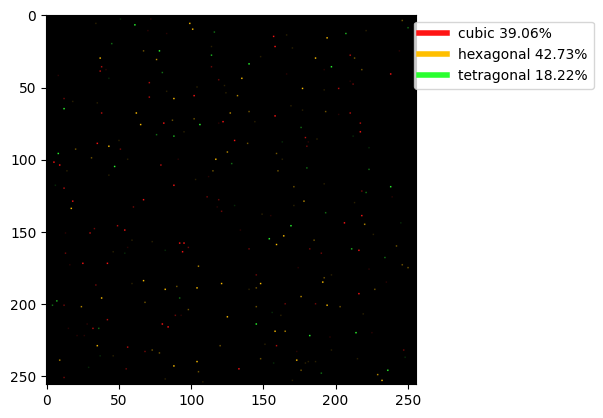

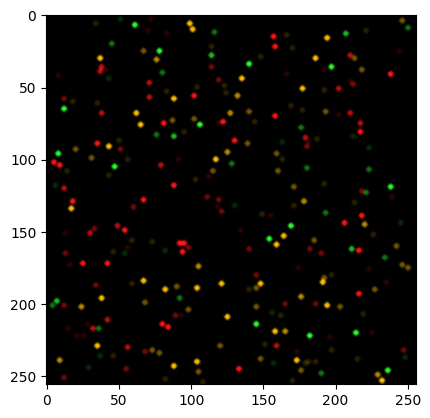

In [80]:
diff_analysis.generate_lattice_cmap(insert_length = 75, resample_length = 75) 
diff_analysis.lattice_cmap

diff_analysis.visualize_real_space_predictions(im_shape = (256, 256),
                                                plot_result = True,
                                                cry_sys = [
                                                    'cubic',
                                                    'hexagonal',
                                                    'tetragonal',
                                                    # 'trigonal',
                                                    # 'orthorhombic',
                                                    # 'monoclinic',
                                                ], 
                                                mask_threshold=mask_keep,
                                              lattice_param = 'a')

median 4.03
mean 4.08


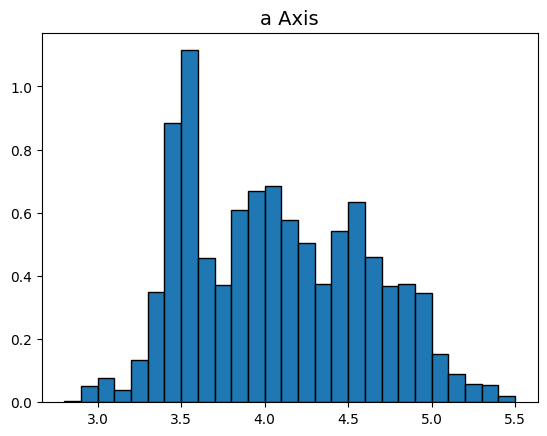

In [81]:
diff_analysis.visualize_lattice_distributions(im_shape = (256,256), lattice_params = ['a'],
                                             crystal_systems = ['one'])

5


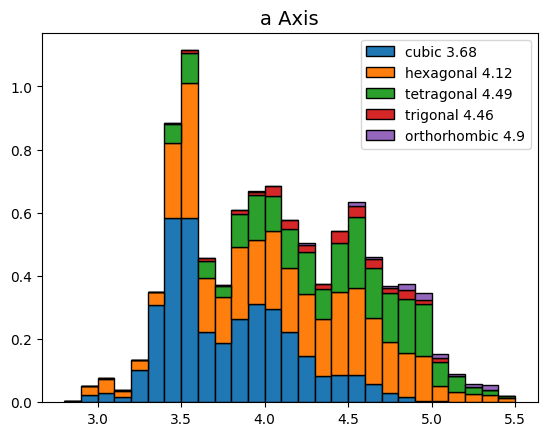

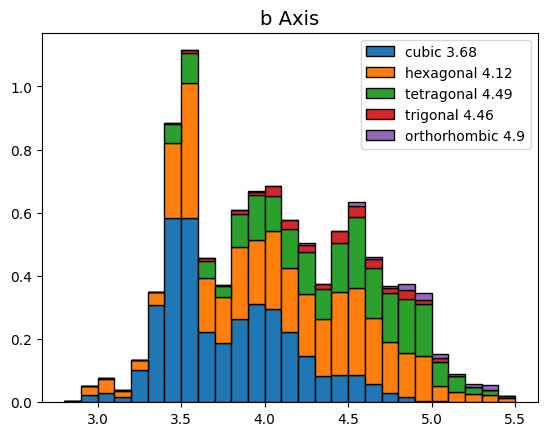

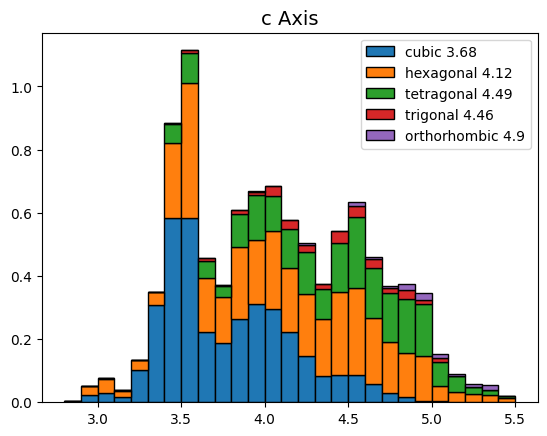

In [82]:
diff_analysis.visualize_lattice_distributions(im_shape = (256,256), lattice_params = ['a', 'b', 'c'],
                                             crystal_systems = ('cubic', 'hexagonal', 'tetragonal', 'trigonal', 'orthorhombic'))

3


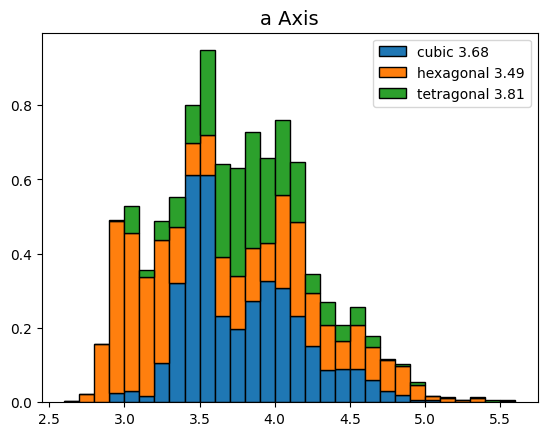

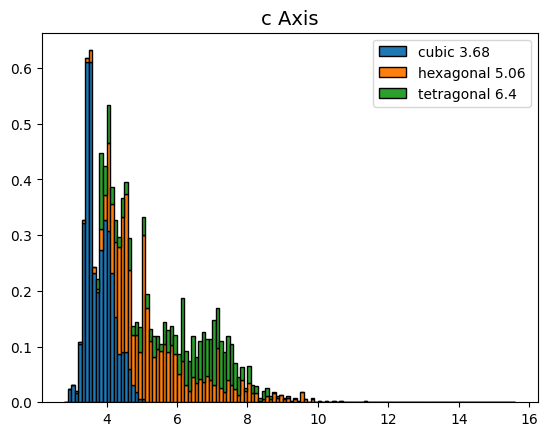

In [73]:
diff_analysis.visualize_lattice_distributions(im_shape = (256,256), lattice_params = ['a', 'c'],
                                             crystal_systems = ('cubic', 'hexagonal', 'tetragonal'))

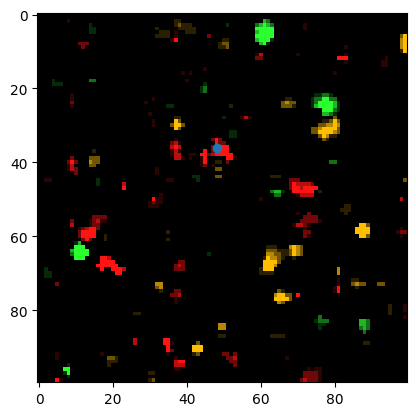

In [29]:
plt.scatter(48,36)
plt.imshow(diff_analysis.pred_image[:100:,:100])

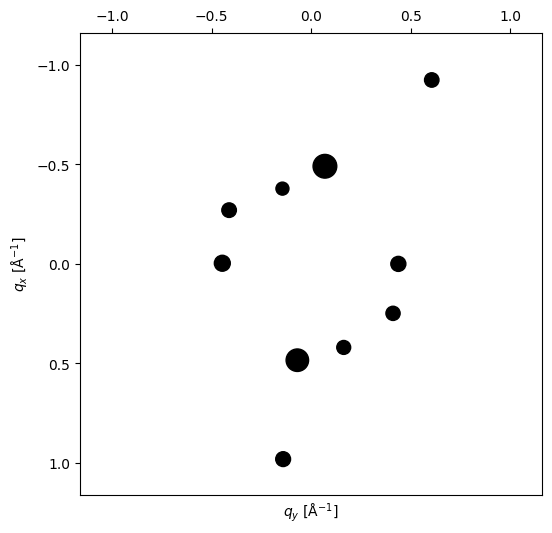

In [30]:
fig = visualize_specific_pattern(
    diff_analysis.pls, 
    index = (36,48) ,
    intensity_scaling = 1,
    )
plt.rcParams['pdf.fonttype'] = 'truetype'
fig.savefig('cubic_pattern.pdf', bbox_inches="tight")


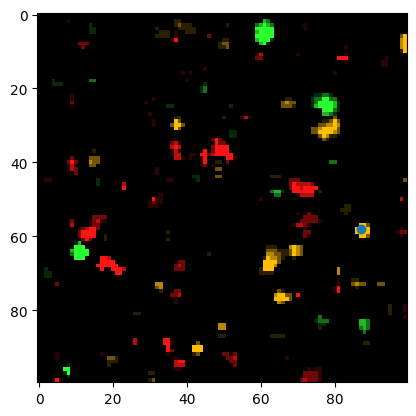

In [31]:
plt.scatter(87,58)
plt.imshow(diff_analysis.pred_image[:100:,:100])

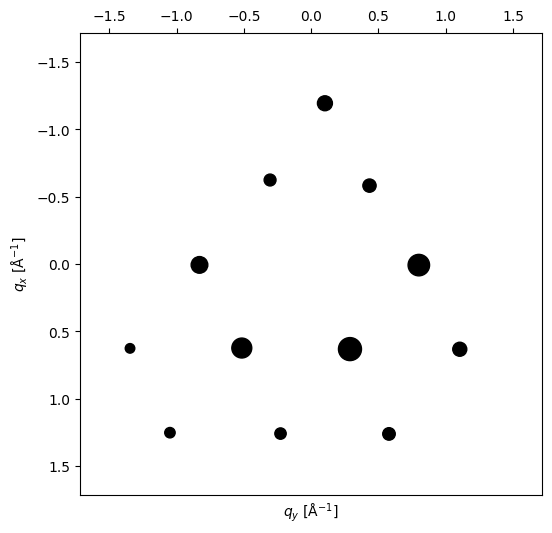

In [32]:
fig = visualize_specific_pattern(
        diff_analysis.pls, 
        index = (58,87) ,
        intensity_scaling = 1,
        )
plt.rcParams['pdf.fonttype'] = 'truetype'
fig.savefig('hexagonal_pattern.pdf', bbox_inches="tight")

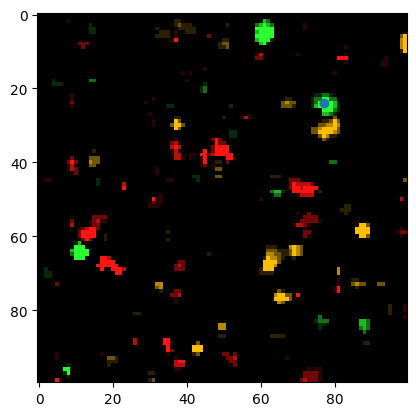

In [33]:
plt.scatter(77,24)
plt.imshow(diff_analysis.pred_image[:100:,:100])

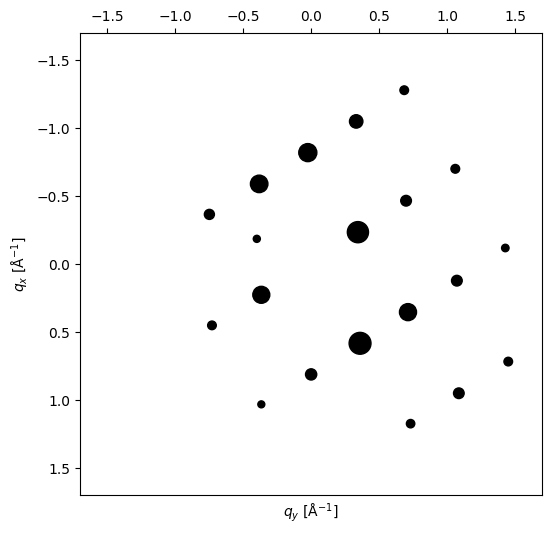

In [34]:
fig = visualize_specific_pattern(
        diff_analysis.pls, 
        index = (24,77) ,
        intensity_scaling = 1,
        )
plt.rcParams['pdf.fonttype'] = 'truetype'
fig.savefig('tetragonal_pattern.pdf', bbox_inches="tight")